In [42]:
import networkx as nx
from Bio import Phylo
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as it
from collections import defaultdict

In [51]:
genome="B"

In [3]:
trees = Phylo.parse("RAxML_bestTree.ASC_GTRGAMMA_felsenstein.{genome}.1000.boot".format(genome=genome),"newick")
trees= [x for x in trees]

In [4]:
nodes=[x.name for x in trees[0].get_terminals()]

In [5]:
def process_tree(tree,nodes):
    G = nx.MultiGraph()
    for (u,v) in it.combinations(nodes,2):
        G.add_edge(u,v,weight=tree.distance(u,v))
    return(nx.minimum_spanning_tree(G,weight="weight"))

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

num_cores = 20
     
mst_trees = Parallel(n_jobs=num_cores)(delayed(process_tree)(i,nodes) for i in trees)


In [37]:
s=pd.read_excel("../Whealbi_500samples_table.xlsx",index_col=0)
s["Genome"]=pd.Categorical(s.Genome.str.replace("\s+","",regex=True))

In [38]:
G = nx.Graph()
for H in mst_trees:
    for (u,v) in H.edges():
        if G.has_edge(u,v):
            G[u][v]["weight"]+=1
        else:
            G.add_edge(u,v,weight=1)

In [39]:
for (u,v,w) in G.edges(data="weight"):
    G[u][v]["weight"]=1-(w / len(mst_trees))
    G[u][v]["weight2"]=(w / len(mst_trees))

In [40]:
GM=nx.minimum_spanning_tree(G)

In [43]:
nn=defaultdict(list)
col=dict()
for n in G.nodes():
    nn[s.Genome.loc[n]].append(n)
    col[s.Genome.loc[n]]=plt.cm.get_cmap('Paired')(s.Genome.cat.codes.loc[n])

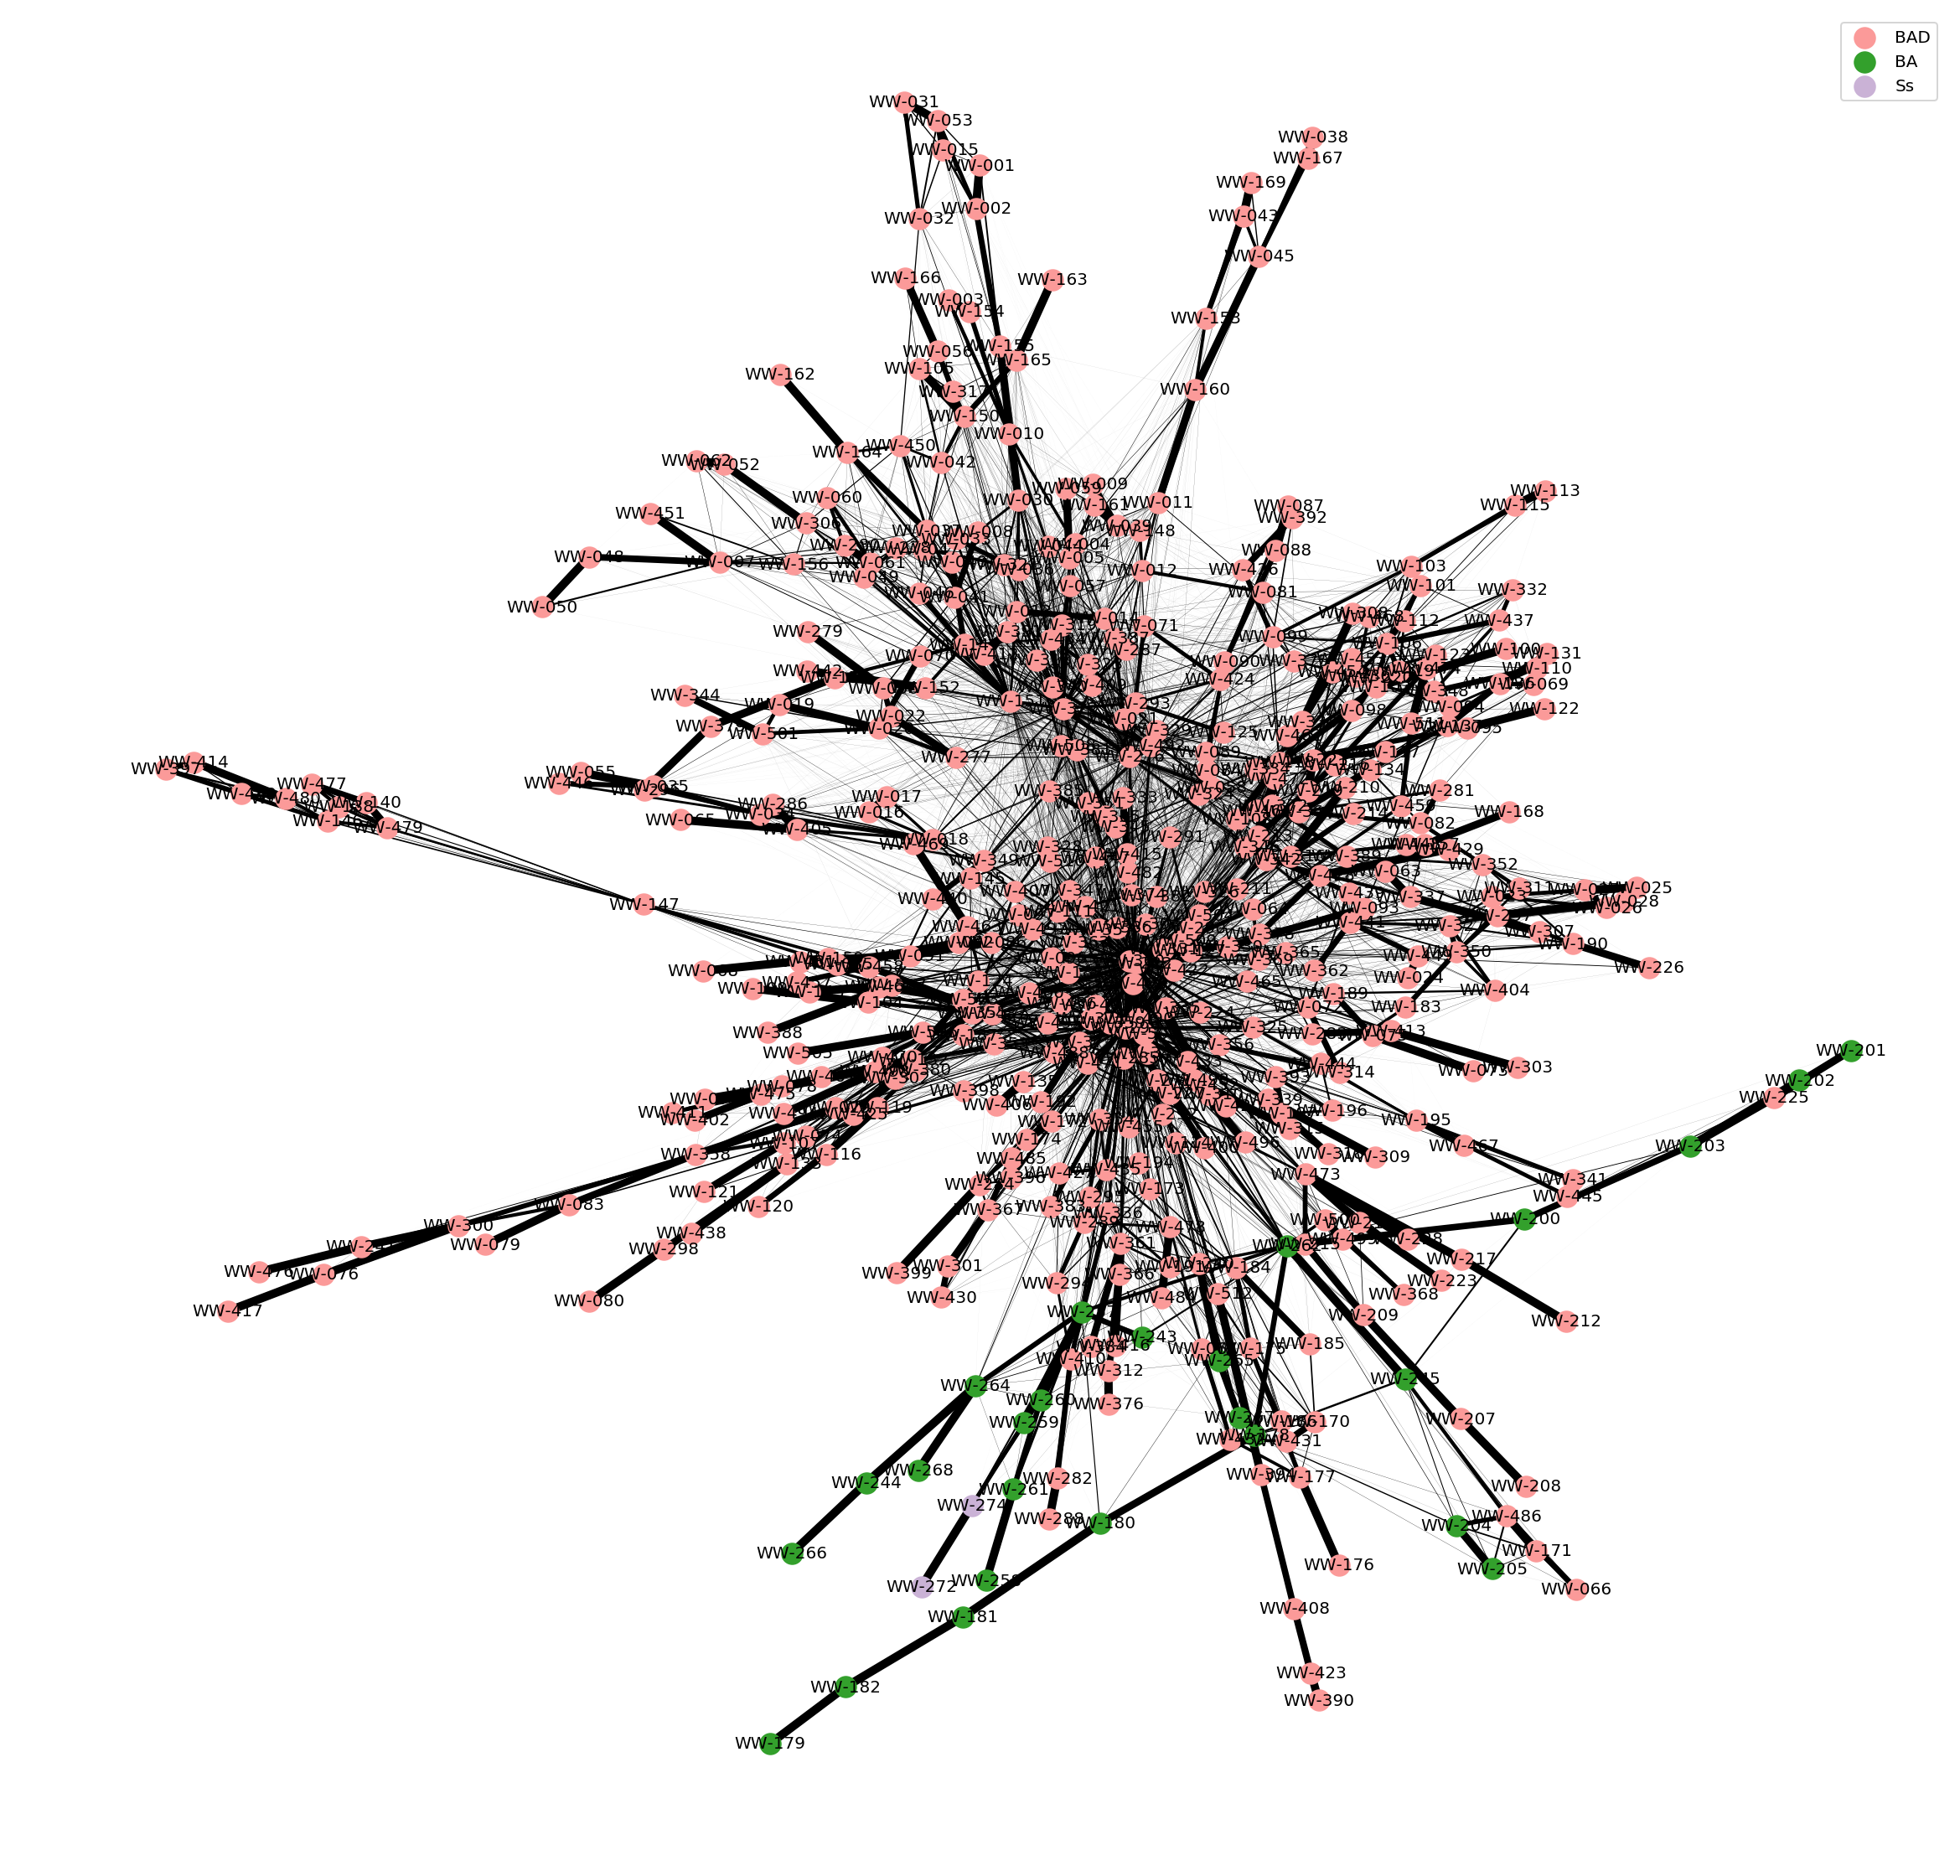

In [44]:
pos=nx.spring_layout(G,weight="weight2")
edgewidth = [ (d['weight2'])*5 for (u,v,d) in G.edges(data=True)]
#nx.draw(GM,cmap=plt.cm.Paired,ax=None)
for genome in nn.keys():
    nx.draw_networkx_nodes(G,pos=pos,nodelist=nn[genome],node_color=col[genome],
                           label=genome,cmap=plt.cm.Paired,node_size=150)

nx.draw_networkx_edges(G, pos, width=edgewidth,)
nx.draw_networkx_labels(G,pos,font_size=10)
plt.rcParams['figure.figsize'] = (20, 20)
%config InlineBackend.figure_format='retina'
plt.legend(loc='best')
plt.axis('off')
pl.show()

In [45]:
nn=defaultdict(list)
col=dict()
for n in GM.nodes():
    nn[s.Genome.loc[n]].append(n)
    col[s.Genome.loc[n]]=plt.cm.get_cmap('Paired')(s.Genome.cat.codes.loc[n])

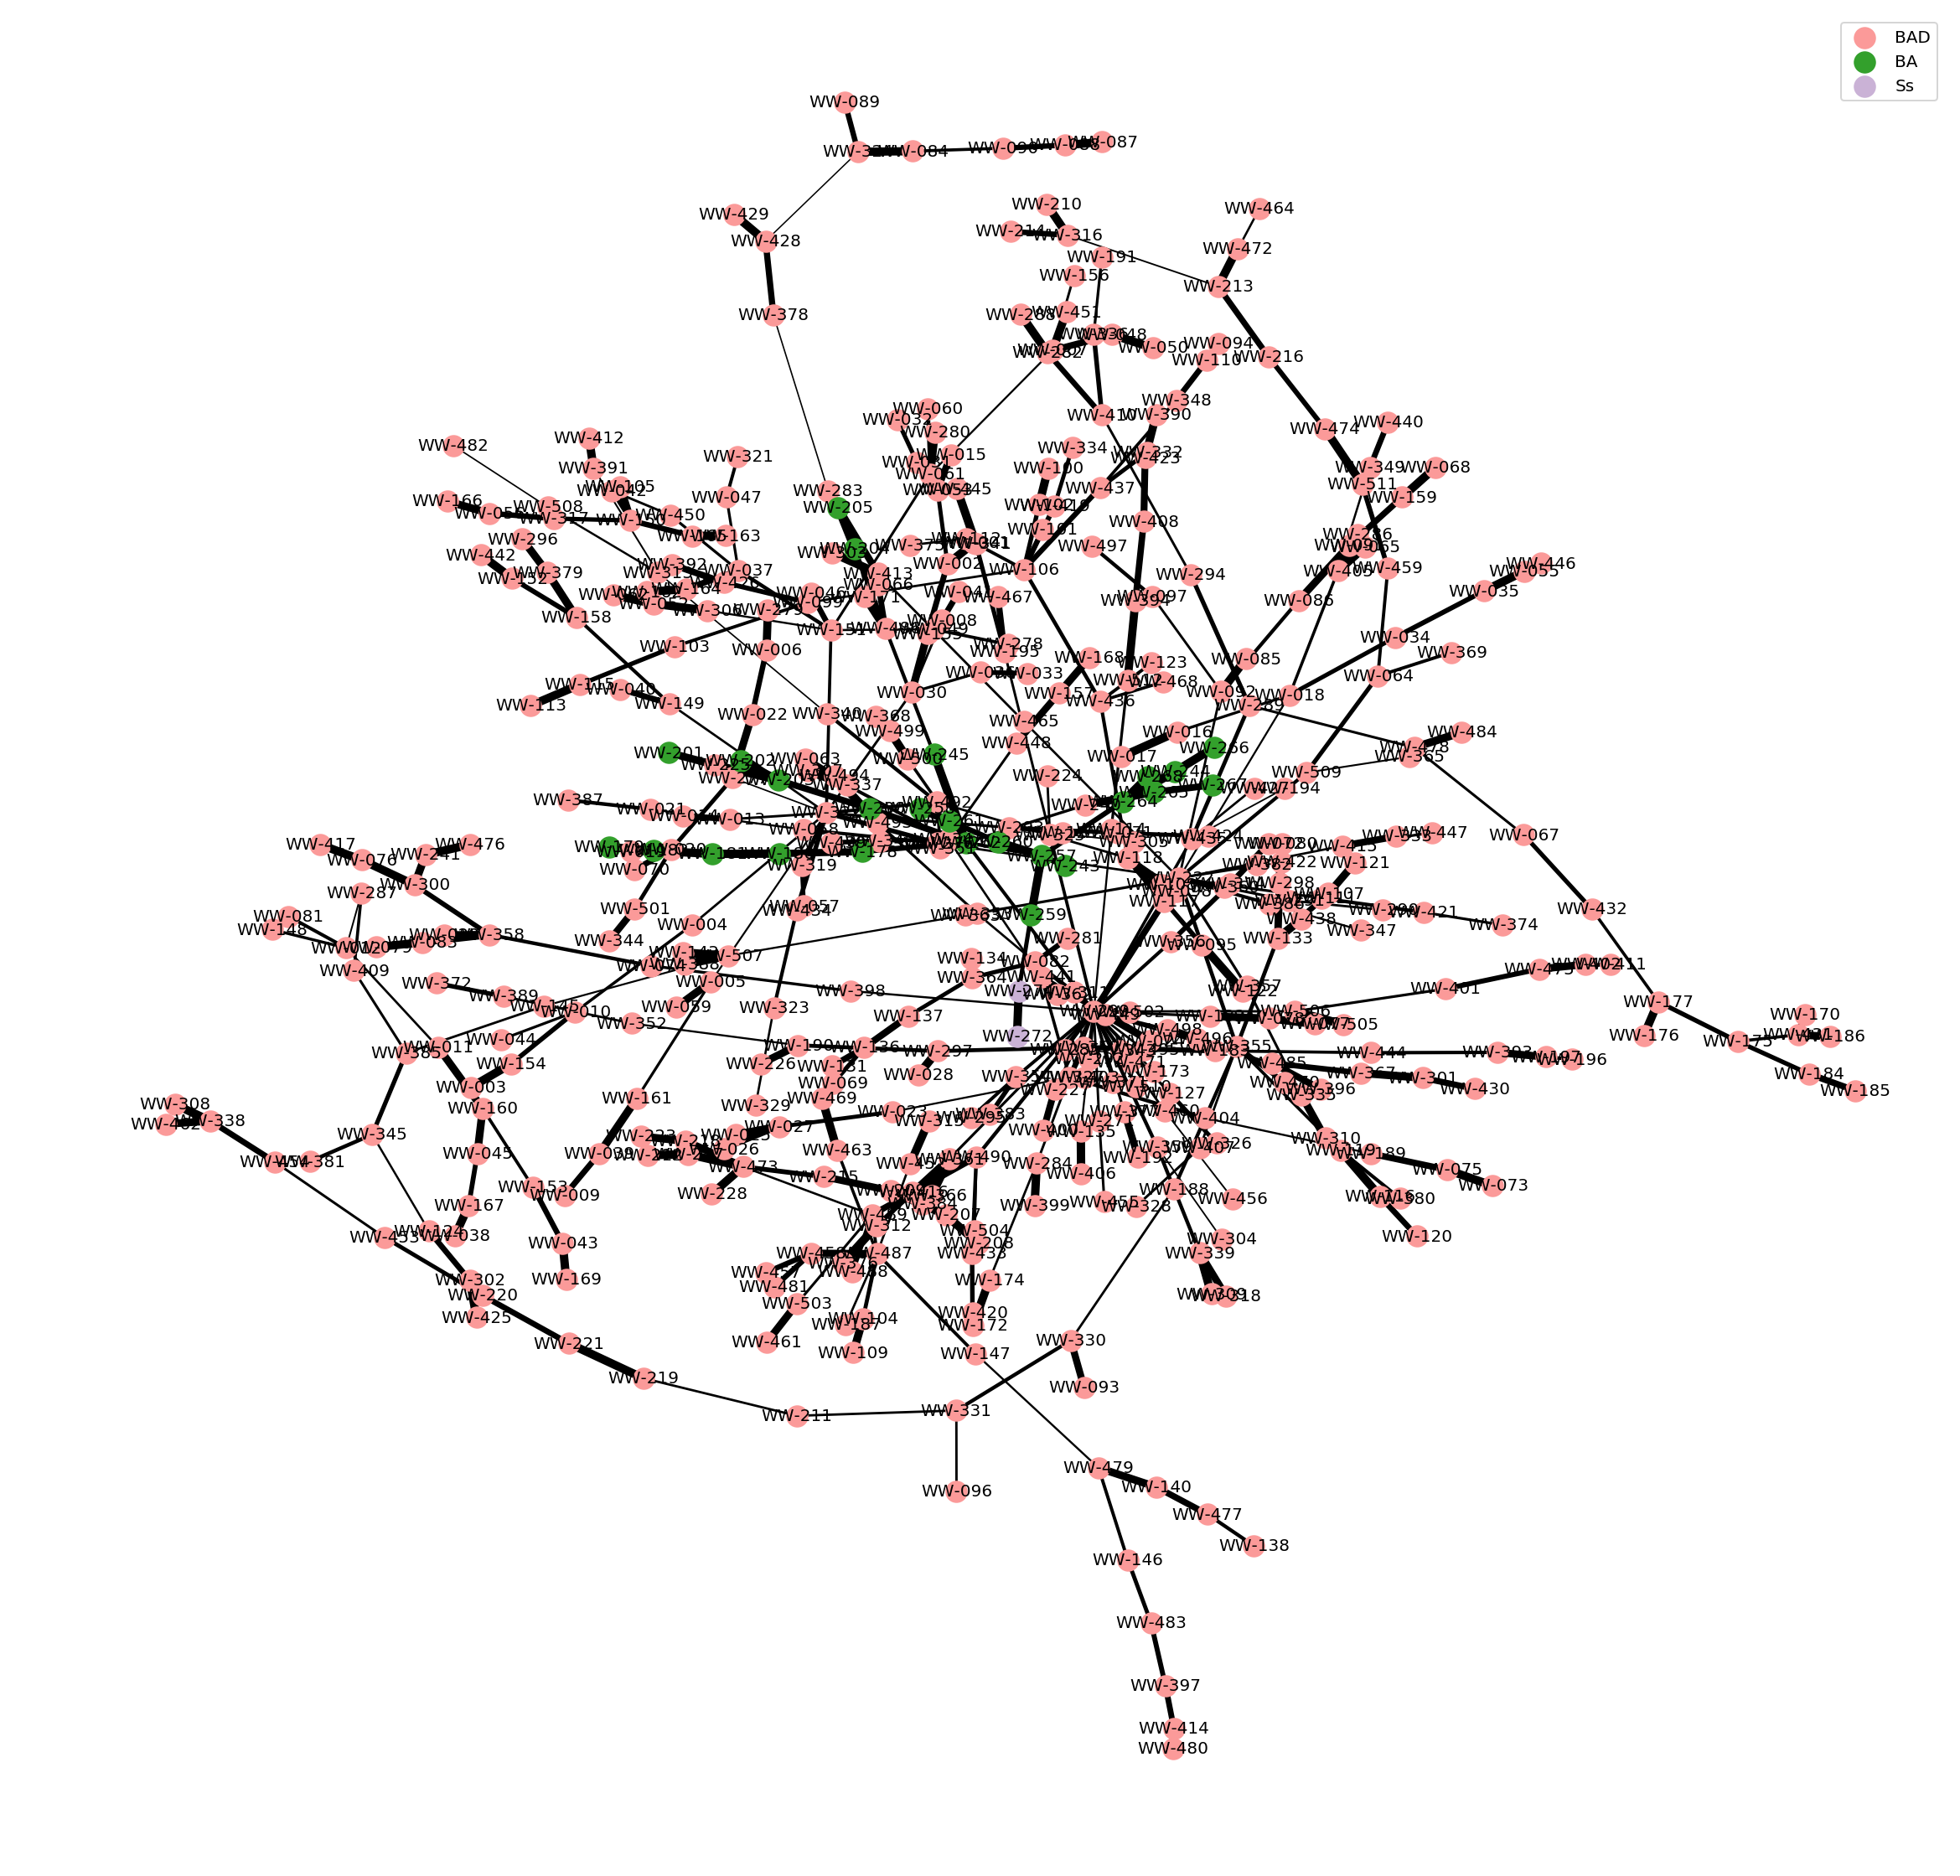

In [46]:
pos=nx.spring_layout(GM,weight="weight2")
edgewidth = [ (d['weight2'])*5 for (u,v,d) in GM.edges(data=True)]
#nx.draw(GM,cmap=plt.cm.Paired,ax=None)
for genome in nn.keys():
    nx.draw_networkx_nodes(GM,pos=pos,nodelist=nn[genome],node_color=col[genome],
                           label=genome,cmap=plt.cm.Paired,node_size=150)

nx.draw_networkx_edges(GM, pos, width=edgewidth,)
nx.draw_networkx_labels(GM,pos,font_size=10)
plt.rcParams['figure.figsize'] = (20, 20)
%config InlineBackend.figure_format='retina'
plt.legend(loc='best')
plt.axis('off')
pl.show()

In [52]:
nx.write_edgelist(G,"Consensus_network.1000_RAxML.{genome}.tsv".format(genome=genome),data=["weight2"])

In [53]:
nx.write_edgelist(GM,"Consensus_network.1000_RAxML2MST.{genome}.tsv".format(genome=genome),data=["weight2"])